発話音声に含まれる周波数をヒストグラムで可視化します．

電話の周波数帯域を参考にして，どのようなバンドパスをかけるか決める．
https://xtech.nikkei.com/it/atcl/column/14/228621/100100019/

かけるバンドパスは，
- 50~7000(VoLTE)
- 300~3400(旧規格)
- 50~3400(squash)
- 300~7000(squash)．

余裕があったら
- 50~300
- 3400~7000
もやってみる(不要とされる周波数帯の成分を見てみたいため)．

In [1]:
# 環境構築
!pip install librosa ipython numpy matplotlib japanize-matplotlib scipy soundfile speechbrain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 18.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

WAV_PAIR_LIST_DIR = "/content/drive/MyDrive/CS_seminar/9th/data/list"
PWD = "/content/drive/MyDrive/CS_seminar/9th"

import librosa
import numpy as np
import os
from matplotlib import pyplot as plt
import IPython
from scipy import signal
import soundfile
import itertools
import japanize_matplotlib

%cd {PWD}/src
import eer_pipeline

Mounted at /content/drive
/content/drive/MyDrive/CS_seminar/9th/src


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [3]:
%cd /content/

/content


音声ファイルのパスを得る

出力してあるリスト->setに変換する

In [4]:
# 発話ペアリストを読む
wav_path_pc = set()
wav_path_sp = set()

def get_wav_path_set(pair_list_path: str) -> set:
  ret_set = set()
  with open(pair_list_path, 'r') as list_file:
    lines = list_file.readlines()
    for line in lines:
      items = line.split(' ')
      ret_set.add(items[1])
      ret_set.add(items[2].rstrip('\n'))
  return ret_set


wav_path_pc = get_wav_path_set(f"{WAV_PAIR_LIST_DIR}/pc.txt")
print(f"wav_path_pc size: {len(wav_path_pc)}") # 49, 発話数と一致．

wav_path_sp = get_wav_path_set(f"{WAV_PAIR_LIST_DIR}/sp.txt")
print(f"wav_path_sp size: {len(wav_path_sp)}") # 49, 発話数と一致．

wav_path_pc size: 49
wav_path_sp size: 49


いくらかバンドパスをかけてみる

関数本体はniwa先輩の実装をお借りしました．お忙しい中ありがとうございます．

In [5]:
# wave: フィルタをかけたい音声
# fs: サンプリング周波数(今回は16000)
# fe: ローパスフィルタの場合はfeよりも低い周波数成分を通す
#     ハイパスフィルタの場合はfeよりも高い周波数成分を通す
#     バンドパスフィルタの場合はfe1以上fe2以下の周波数成分を通す
# n: フィルタの次数(あんまり気にしないで良いです)

# ローパスフィルタ
def lpf(wave, fs, fe, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave


# ハイパスフィルタ
def hpf(wave, fs, fe, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='high')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave


# バンドパスフィルタ
def bpf(wave, fs, fe1, fe2, n):
    nyq = fs / 2.0
    b, a = signal.butter(1, [fe1/nyq, fe2/nyq], btype='band')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

In [6]:
def is_same_speaker(path1, path2):
  # path文字列を解析して，パス対が同じ話者であるかを判定
  name1 = path1.split('/')[-3]
  name2 = path2.split('/')[-3]
  # # re(正規表現)による実装．今回のpathであればsplit('/')でいいが，複雑な区切り文字とかになると正規表現を用いた方が良い場面も出てくる．
  # dir1 = re.match(r"(.*/).+\.wav", path1).group(1)
  # dir2 = re.match(r"(.*/).+\.wav", path2).group(1)
  return int(name1 == name2)

def gen_2pair_listfile(path_list, outfile_path):
  outfile = open(outfile_path, 'w')
  out_info = {
      "filename": outfile_path,
      "total_wavs": len(path_list),
      "total_pairs": len(path_list) * (len(path_list)-1) // 2,
      "same_pair": 0,
      "diff_pair": 0,
  }
  # itertools.combinations()による実装．
  # 組み合わせをforで構築するのは，`CS_seminar/4th/*/gen_list.py`を参照のこと．
  pairs = list(itertools.combinations(path_list, 2))
  for pair in pairs:
    same_spk = is_same_speaker(*pair)
    outstr = f"{same_spk} {pair[0]} {pair[1]}\n"
    outfile.write(outstr)
    # ペア数を記録
    if same_spk:
      out_info["same_pair"] += 1
    else:
      out_info["diff_pair"] += 1
  outfile.close()
  return out_info

def bpf_pipeline(wav_path_list: list[str], bpf_range: tuple, out_list_path: str) -> None:
  filted_wav_path = []
  for wav_path in wav_path_list:
    wave_vanilla, sr = librosa.load(wav_path, sr=16000)
    new_file_name = f"{wav_path[:-4]}_{bpf_range[0]}-{bpf_range[1]}.wav"
    wave_filt = bpf(
        wave_vanilla,
        fs=sr,
        fe1=bpf_range[0], fe2=bpf_range[1],
        n=5
    )
    # print(new_file_name)
    soundfile.write(
        file=new_file_name,
        data=wave_filt,
        samplerate=sr
    )
    filted_wav_path.append(new_file_name)

    gen_2pair_listfile(filted_wav_path, out_list_path)

In [22]:
from genericpath import exists
def save_spectrogram(wav_path: str, outfile_path: str) -> None:
  #FFT点数
  n_fft = 2048
  #窓長
  win_length = 1024
  #シフト量
  hop_length = win_length//4
  #音声ロード
  x, sr = librosa.load(wav_path, sr=16000)
  #短時間フーリエ変換
  D = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)

  #Dは複素数なので絶対値をとって振幅を得る
  S = np.abs(D)

  #デシベルに変換
  db = librosa.amplitude_to_db(S, ref=np.max)

  #スペクトログラム表示
  fig, ax = plt.subplots()
  img = librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='linear')
  ax.set_title("スペクトログラム", fontsize=18) #タイトルの設定,なんかフォントサイズが小さかったのでサイズを変更
  ax.set_xlabel("時間(s)") #x軸の設定
  ax.set_ylabel("周波数(Hz)") #y軸の設定
  os.makedirs(f"{PWD}/fig/pc_{bpf_range[0]}-{bpf_range[1]}", exist_ok=True)
  plt.savefig(outfile_path, dpi=600)

---


In [8]:
%cd /content/

/content


In [31]:
def run(bpf_range):
  # gen file and pair list
  bpf_pipeline(list(wav_path_pc), bpf_range, f"{PWD}/data/list/pc_{bpf_range[0]}-{bpf_range[1]}.txt")
  bpf_pipeline(list(wav_path_sp), bpf_range, f"{PWD}/data/list/sp_{bpf_range[0]}-{bpf_range[1]}.txt")

  # PC: calc and plot eer
  print("--PC tasks started.--")
  eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/pc_{bpf_range[0]}-{bpf_range[1]}.txt", PWD)
  save_spectrogram(
    f"{PWD}/data/wav/ymgt_A/pc/ymgt-A_pc_01.wav",
    f"{PWD}/fig/pc_{bpf_range[0]}-{bpf_range[1]}/vanilla.png"
  )
  save_spectrogram(
      f"{PWD}/data/wav/ymgt_A/pc/ymgt-A_pc_01_{bpf_range[0]}-{bpf_range[1]}.wav",
      f"{PWD}/fig/pc_{bpf_range[0]}-{bpf_range[1]}/bpfed.png"
  )

  # SP: calc and plot eer
  print("--SP tasks started.--")
  eer_pipeline.eer_roc_pipeline(f"{PWD}/data/list/sp_{bpf_range[0]}-{bpf_range[1]}.txt", PWD)
  save_spectrogram(
    f"{PWD}/data/wav/ymgt_A/sp/ymgt-A_sp_01.wav",
    f"{PWD}/fig/sp_{bpf_range[0]}-{bpf_range[1]}/vanilla.png"
  )
  save_spectrogram(
      f"{PWD}/data/wav/ymgt_A/sp/ymgt-A_sp_01_{bpf_range[0]}-{bpf_range[1]}.wav",
      f"{PWD}/fig/sp_{bpf_range[0]}-{bpf_range[1]}/bpfed.png"
  )

## 50~7000Hz

100%|██████████| 1176/1176 [00:49<00:00, 23.91it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_50-7000.txt
pairs:1176
eer: 0.1709401709401725
eer_th: 0.16399002931203774
FalseNegatives(eer_th:0.16399002931203774)
score:0.09943586587905884 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_02_50-7000.wav
score:0.13254214823246002 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_07_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_50-7000.wav
score:0.031090740114450455 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_04_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_06_50-7000.wav
score:0.1482984721660614 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_F/pc/ymgt-F_pc_06_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_F/pc/ymgt-F_pc_04_50-7000.wav
score:0.03110692650079727 /content/drive/MyDrive/CS_semina

100%|██████████| 1176/1176 [00:41<00:00, 28.04it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_50-7000.txt
pairs:1176
eer: 0.11803588290839132
eer_th: 0.20015816390516017
FalseNegatives(eer_th:0.20015816390516017)
score:0.08401065319776535 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_05_50-7000.wav
score:0.17880025506019592 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_03_50-7000.wav
score:0.17516648769378662 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_05_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_02_50-7000.wav
score:0.11205743998289108 /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp3_50-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp1_50-7000.wav
score:0.06126479059457779 /content/drive/MyDrive/CS_seminar/9th/data/wav/

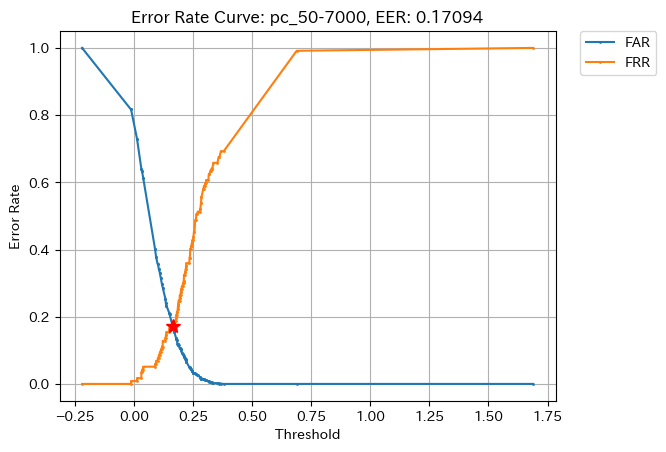

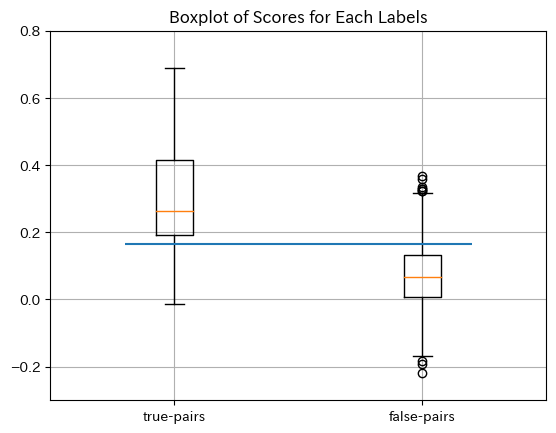

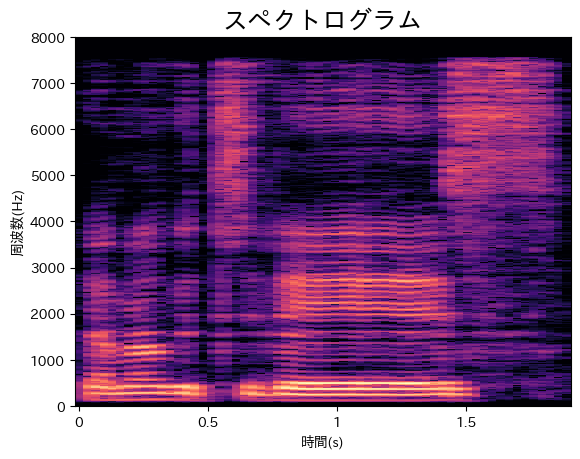

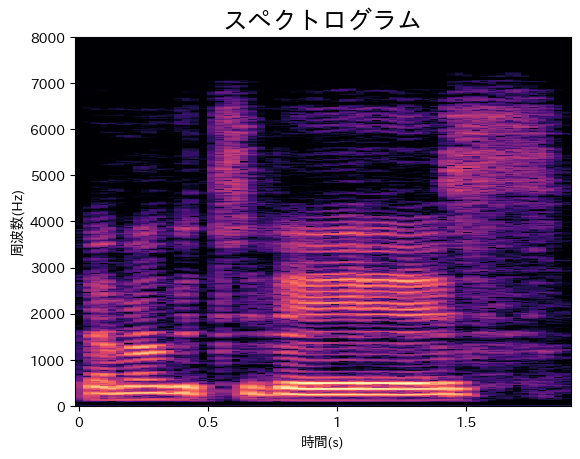

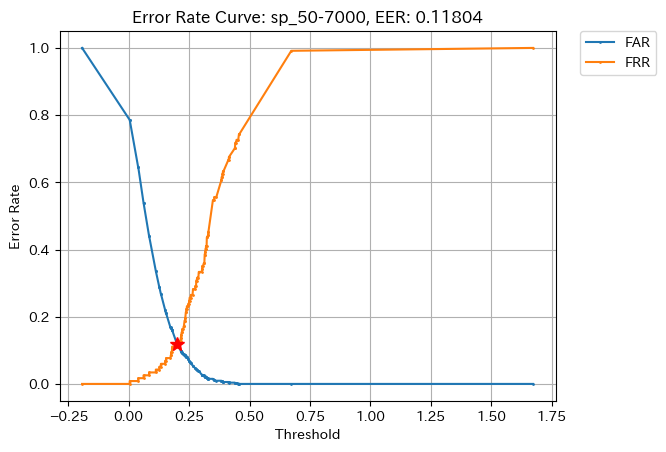

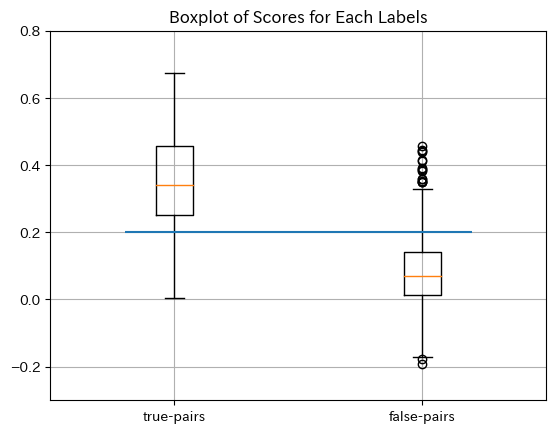

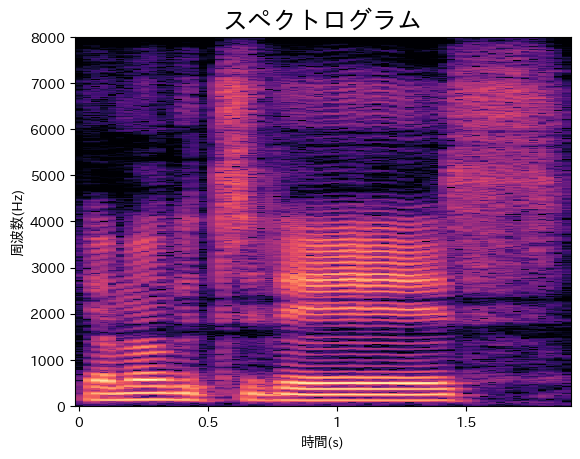

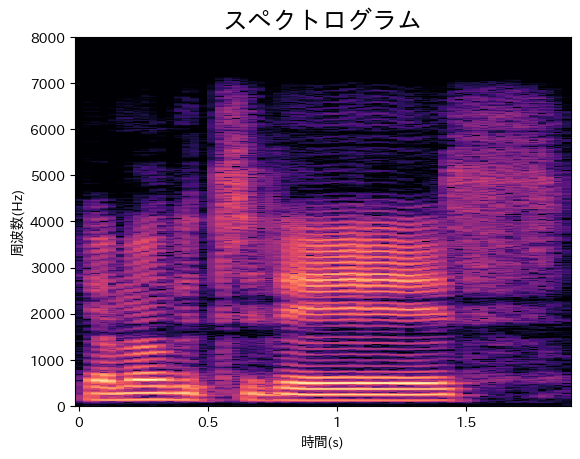

In [27]:
bpf_range = (50, 7000)
run(bpf_range)

## 300~3400
電話の周波数帯がコレなので．

--PC tast started.--


100%|██████████| 1176/1176 [00:46<00:00, 25.33it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_300-3400.txt
pairs:1176
eer: 0.2307692307688651
eer_th: 0.18235608247621285
FalseNegatives(eer_th:0.18235608247621285)
score:0.14812618494033813 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_02_300-3400.wav
score:0.1791025698184967 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_05_300-3400.wav
score:0.1664050668478012 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_07_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_04_300-3400.wav
score:0.1130874827504158 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_04_300-3400.wav
score:0.1636601984500885 /content/drive/MyDrive/CS_s

100%|██████████| 1176/1176 [00:45<00:00, 25.82it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_300-3400.txt
pairs:1176
eer: 0.17948717948717954
eer_th: 0.20703004331855504
FalseNegatives(eer_th:0.20703004331855504)
score:0.20561246573925018 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_06_300-3400.wav
score:0.15042871236801147 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_05_300-3400.wav
score:0.06634315848350525 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_03_300-3400.wav
score:0.09703405201435089 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_C/sp/ymgt-C_sp_01_300-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_C/sp/ymgt-C_sp_06_300-3400.wav
score:0.10613729804754257 /content/drive/MyDrive

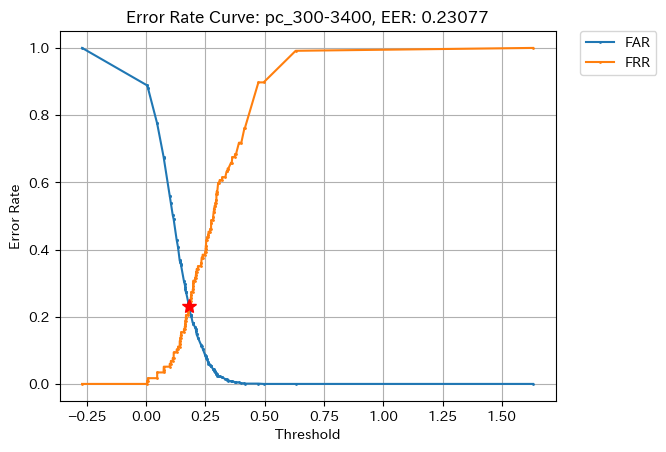

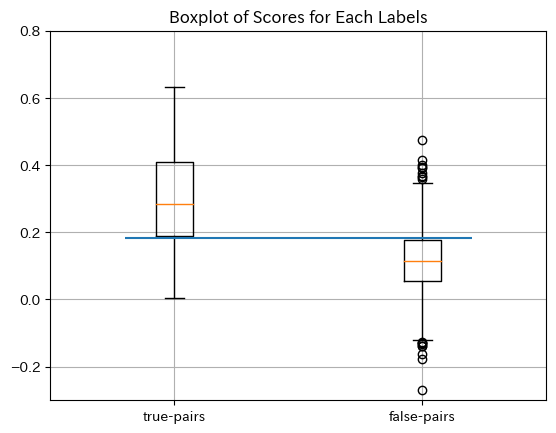

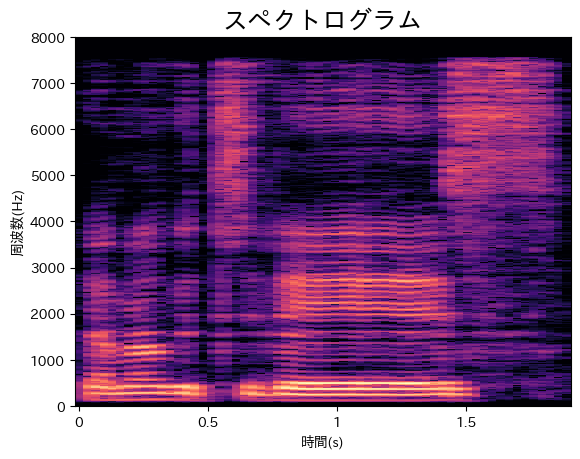

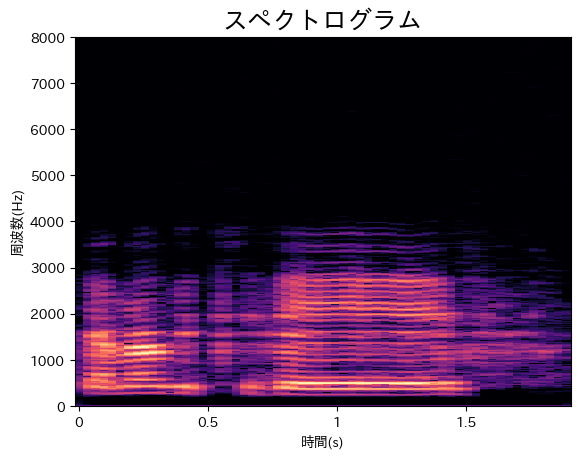

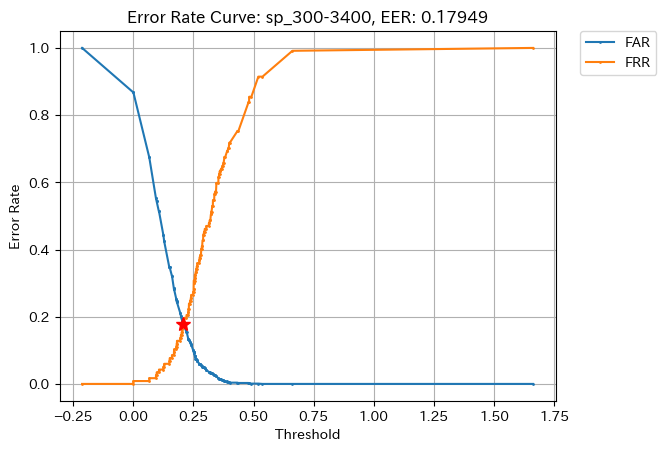

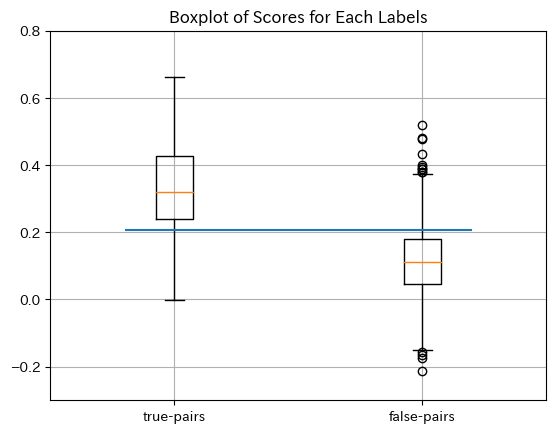

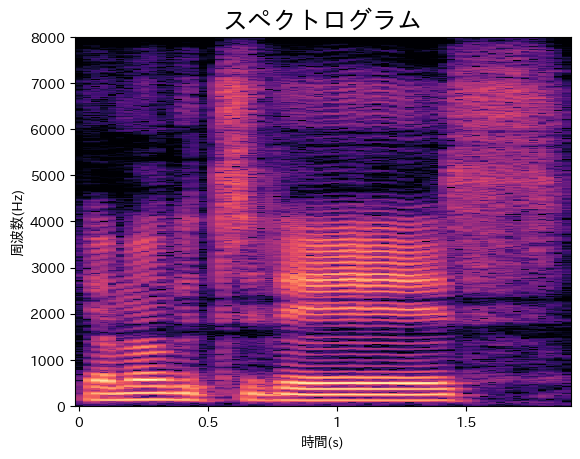

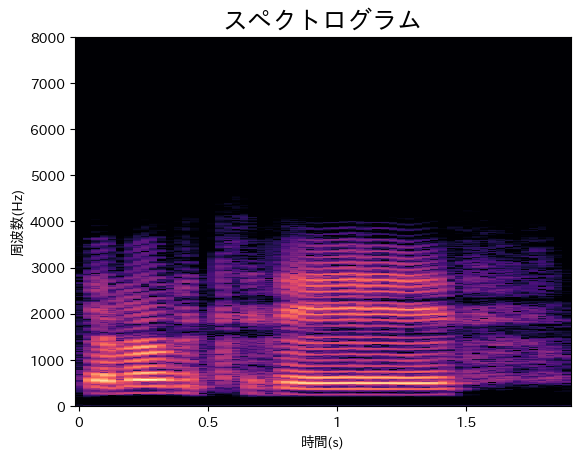

In [30]:
bpf_range = (300, 3400)
run(bpf_range)

## 50~3400



--PC tasks started.--


100%|██████████| 1176/1176 [00:41<00:00, 28.35it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_50-3400.txt
pairs:1176
eer: 0.18803418803443417
eer_th: 0.18128431053493121
FalseNegatives(eer_th:0.18128431053493121)
score:-0.046308793127536774 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_06_50-3400.wav
score:0.028716498985886574 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_05_50-3400.wav
score:0.16245341300964355 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_06_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_05_50-3400.wav
score:0.12641221284866333 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_07_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_05_50-3400.wav
score:0.11907719820737839 /content/drive/MyDrive/CS_se

100%|██████████| 1176/1176 [00:40<00:00, 28.73it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_50-3400.txt
pairs:1176
eer: 0.13786591123600217
eer_th: 0.21203753352184476
FalseNegatives(eer_th:0.21203753352184476)
score:0.10611289739608765 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_06_50-3400.wav
score:0.13020922243595123 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_05_50-3400.wav
score:0.04302095249295235 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_03_50-3400.wav
score:0.2119356393814087 /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp3_50-3400.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp2_50-3400.wav
score:0.16821345686912537 /content/drive/MyDrive/CS_seminar/9th/data/wav/y

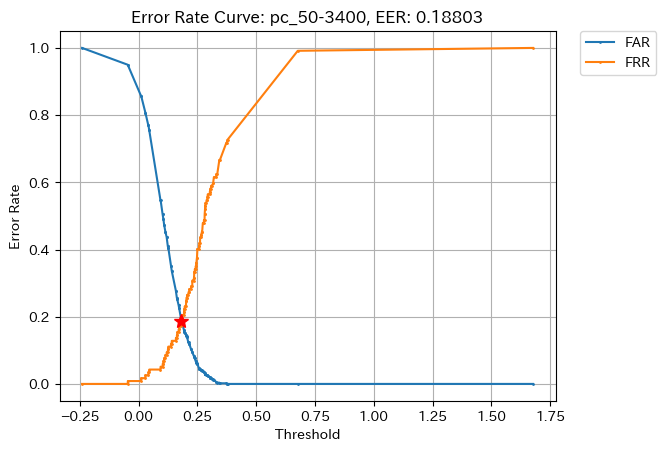

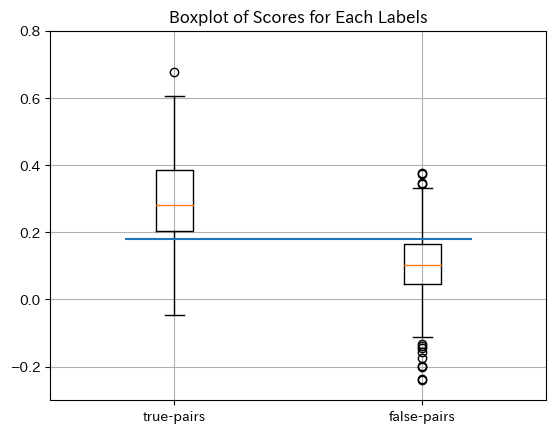

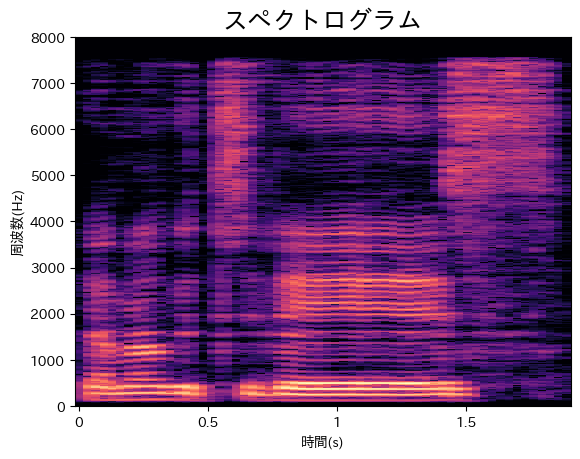

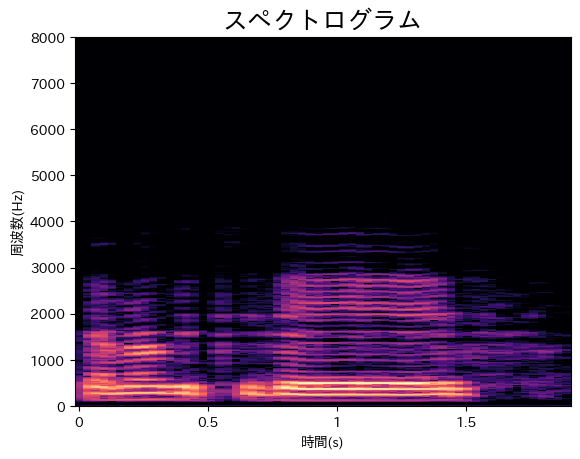

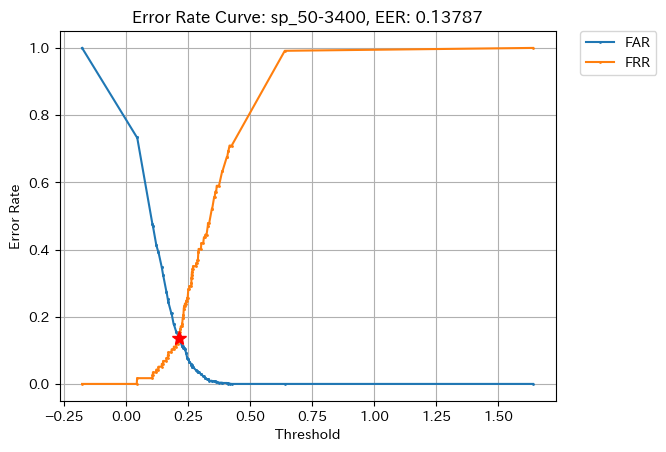

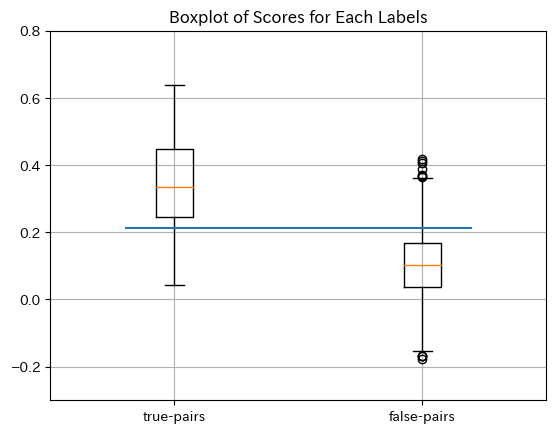

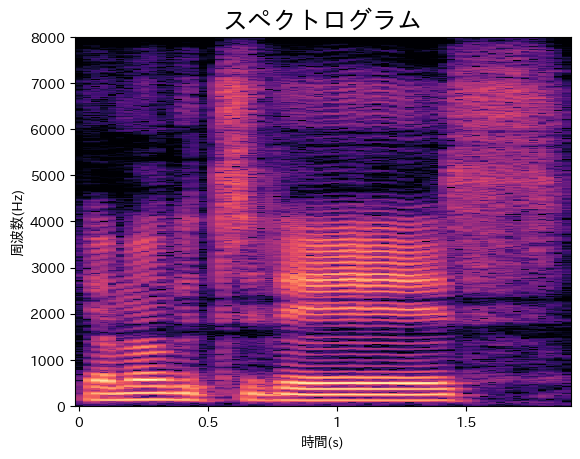

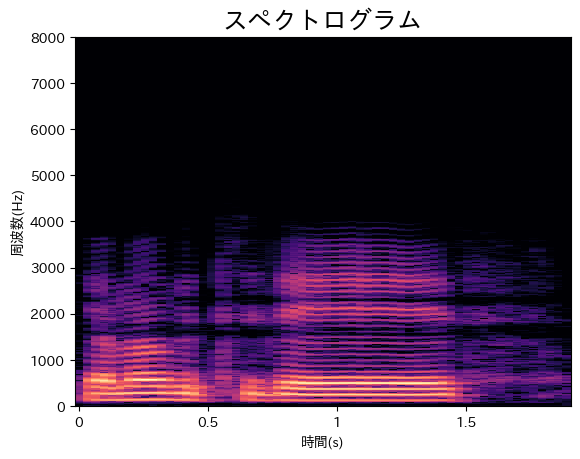

In [32]:
bpf_range = (50, 3400)
run(bpf_range)

## 300~7000

--PC tasks started.--


100%|██████████| 1176/1176 [00:42<00:00, 27.64it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_300-7000.txt
pairs:1176
eer: 0.18803418803408764
eer_th: 0.16095047959918146
FalseNegatives(eer_th:0.16095047959918146)
score:0.16022257506847382 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_07_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_300-7000.wav
score:0.10937198996543884 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_04_300-7000.wav
score:0.11868013441562653 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_04_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_06_300-7000.wav
score:0.15975143015384674 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_04_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/pc/ymgt-D_pc_03_300-7000.wav
score:0.15912732481956482 /content/drive/MyDrive

100%|██████████| 1176/1176 [00:47<00:00, 24.55it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_300-7000.txt
pairs:1176
eer: 0.11965811965812
eer_th: 0.20030708748560666
FalseNegatives(eer_th:0.20030708748560666)
score:0.13377079367637634 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_05_300-7000.wav
score:0.16591694951057434 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_05_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_06_300-7000.wav
score:0.10772684216499329 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_05_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/sp/ymgt-E_sp_02_300-7000.wav
score:0.15808184444904327 /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp3_300-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/tmng/sp/tm_sp1_300-7000.wav
score:0.09622970968484879 /content/drive/MyDrive/CS_seminar/9th/dat

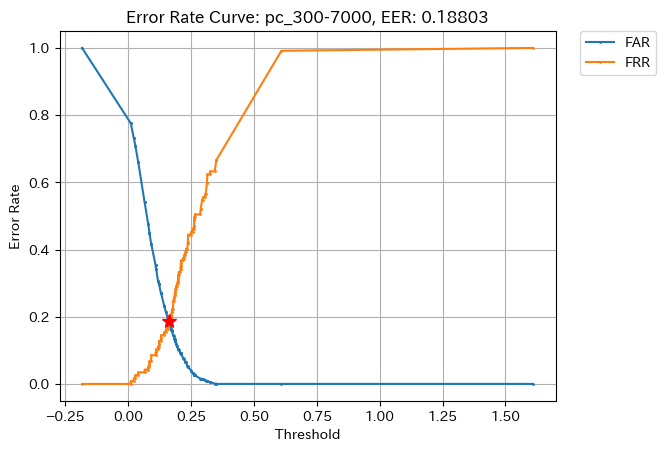

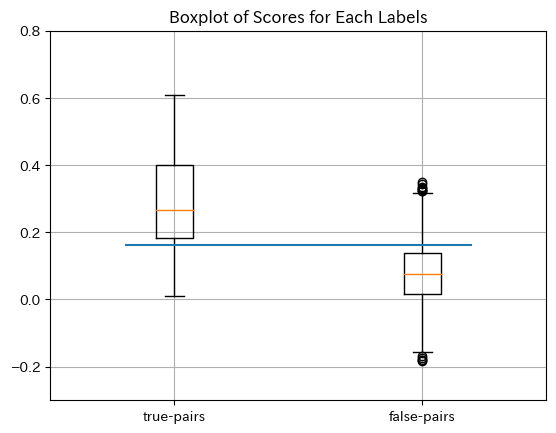

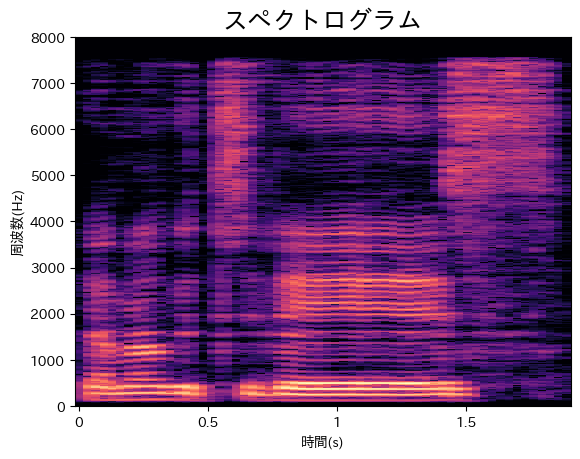

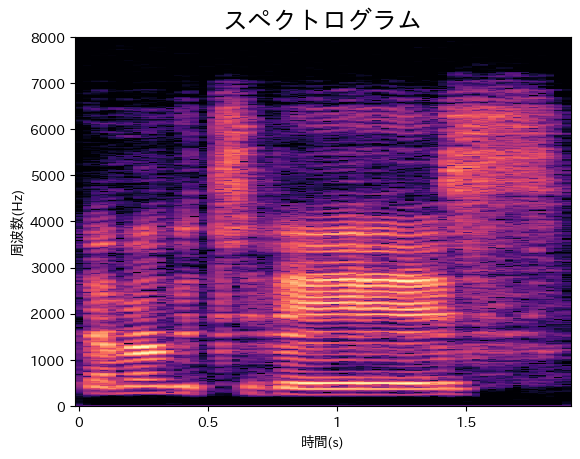

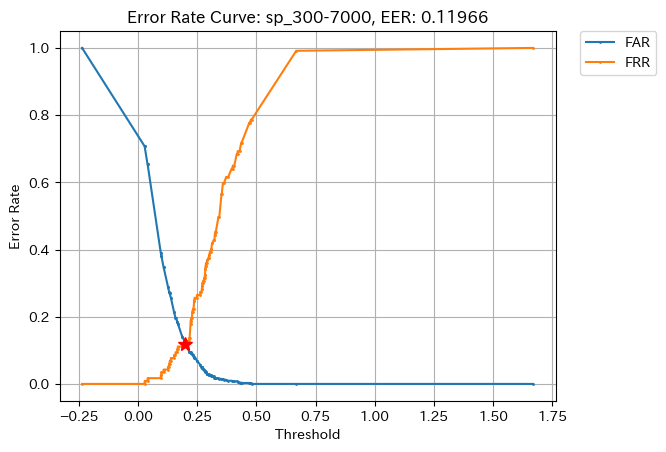

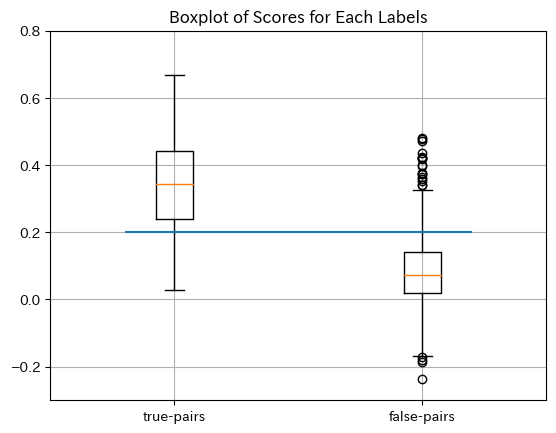

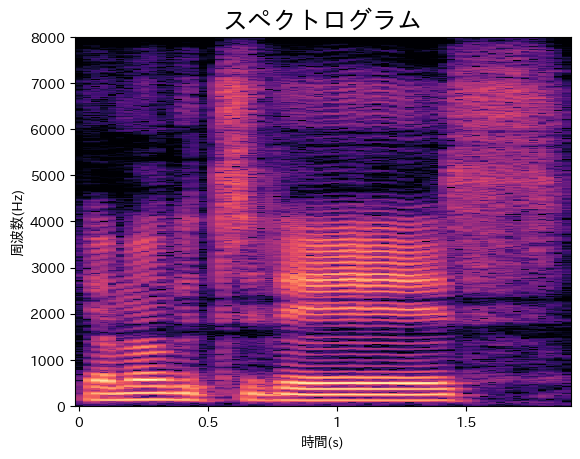

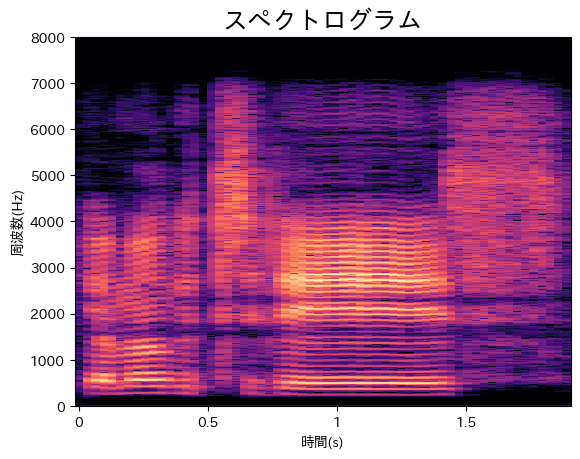

In [33]:
bpf_range = (300, 7000)
run(bpf_range)

## 50~300

--PC tasks started.--


100%|██████████| 1176/1176 [00:42<00:00, 27.94it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_50-300.txt
pairs:1176
eer: 0.2564102564102621
eer_th: 0.46056184012156065
FalseNegatives(eer_th:0.46056184012156065)
score:0.21997004747390747 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_06_50-300.wav
score:0.4161527454853058 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_01_50-300.wav
score:0.43501514196395874 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_06_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_05_50-300.wav
score:0.4447399973869324 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_04_50-300.wav
score:0.4103256165981293 /content/drive/MyDrive/CS_seminar/9th/data/w

100%|██████████| 1176/1176 [00:41<00:00, 28.21it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_50-300.txt
pairs:1176
eer: 0.18035882908474538
eer_th: 0.53570079803445
FalseNegatives(eer_th:0.53570079803445)
score:0.4844597578048706 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_06_50-300.wav
score:0.447506308555603 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_05_50-300.wav
score:0.38400930166244507 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_03_50-300.wav
score:0.36070752143859863 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/sp/ymgt-A_sp_06_50-300.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/sp/ymgt-A_sp_02_50-300.wav
score:0.45520371198654175 /content/drive/MyDrive/CS_seminar/9th/data/wav/ym

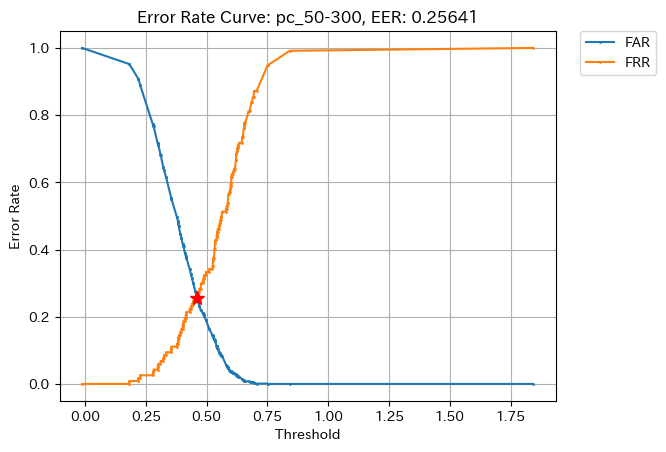

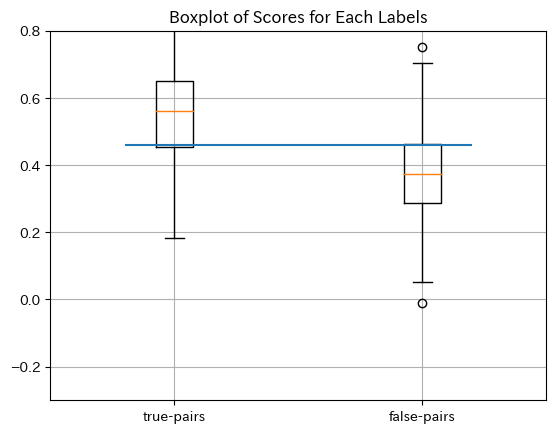

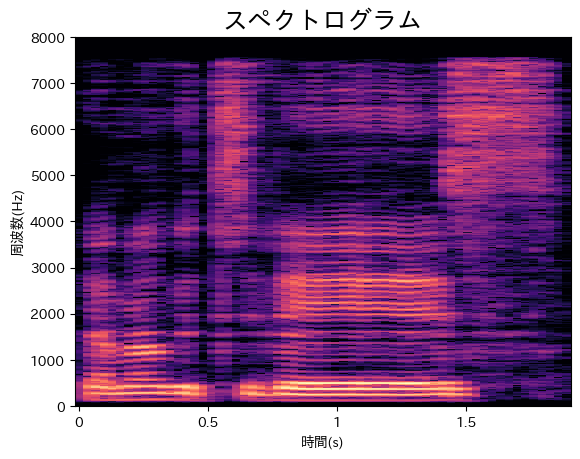

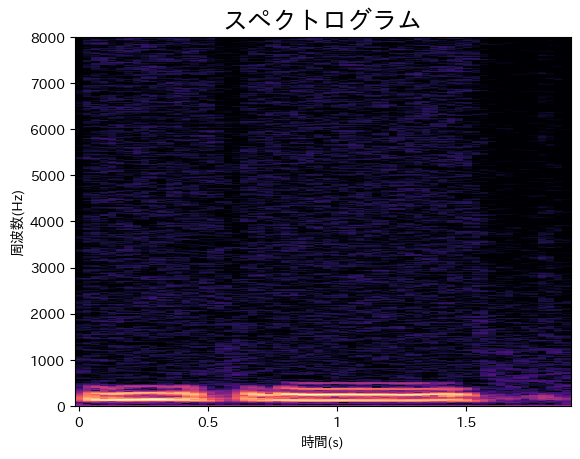

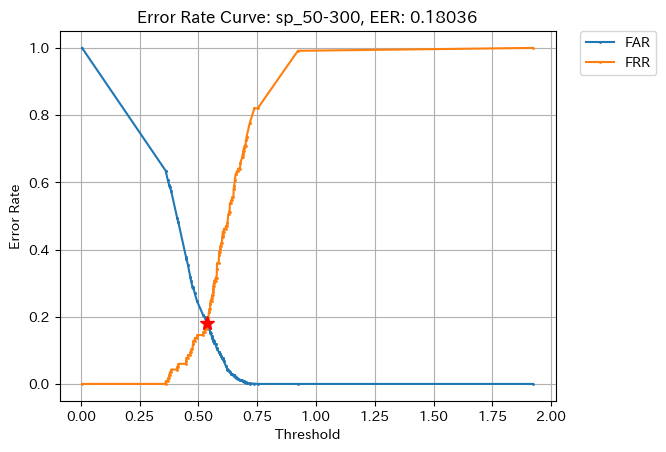

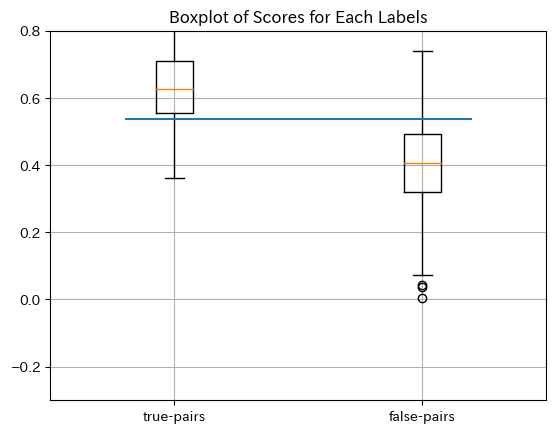

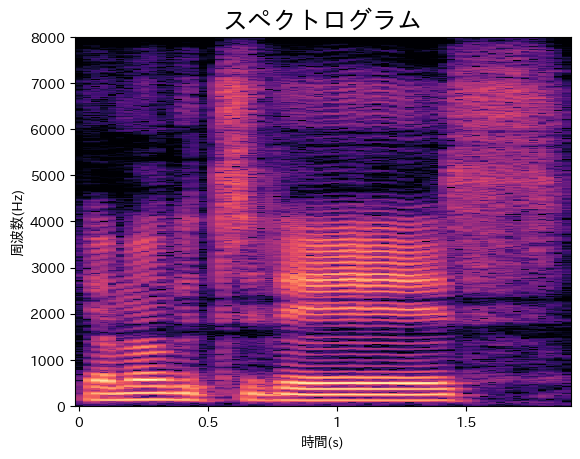

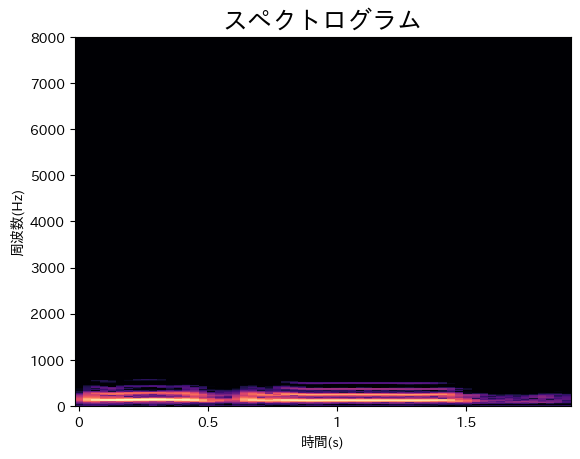

In [34]:
bpf_range = (50, 300)
run(bpf_range)

## 3400~7000

--PC tasks started.--


100%|██████████| 1176/1176 [00:43<00:00, 26.98it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/pc_3400-7000.txt
pairs:1176
eer: 0.4017094017093952
eer_th: 0.33038615747395017
FalseNegatives(eer_th:0.33038615747395017)
score:0.29541411995887756 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_03_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_A/pc/ymgt-A_pc_04_3400-7000.wav
score:0.3006843030452728 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_07_3400-7000.wav
score:0.2883668839931488 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_03_3400-7000.wav
score:0.23584675788879395 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_B/pc/ymgt-B_pc_05_3400-7000.wav
score:0.2650790512561798 /content/drive/My

100%|██████████| 1176/1176 [00:43<00:00, 27.21it/s]


wav_list:/content/drive/MyDrive/CS_seminar/9th/data/list/sp_3400-7000.txt
pairs:1176
eer: 0.2965061378650977
eer_th: 0.33387696743033574
FalseNegatives(eer_th:0.33387696743033574)
score:0.3225383460521698 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_01_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_D/sp/ymgt-D_sp_06_3400-7000.wav
score:0.23561394214630127 /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_05_3400-7000.wav
score:0.3336774706840515 /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_04_3400-7000.wav
score:0.282589316368103 /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_06_3400-7000.wav, /content/drive/MyDrive/CS_seminar/9th/data/wav/ktg/sp/ktg_sp_01_3400-7000.wav
score:0.23407405614852905 /content/drive/MyDrive/CS_seminar/9th/data/wav/ymgt_E/

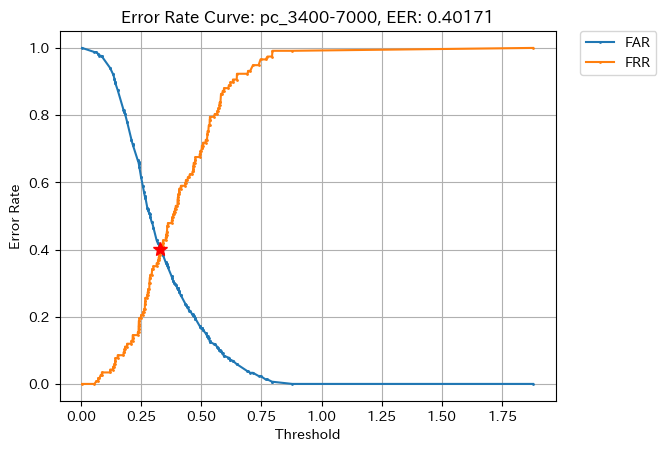

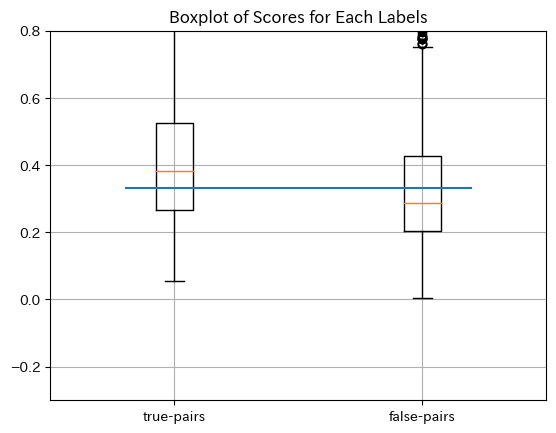

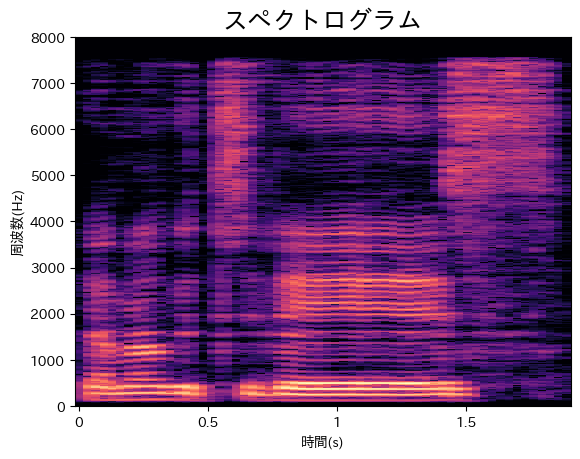

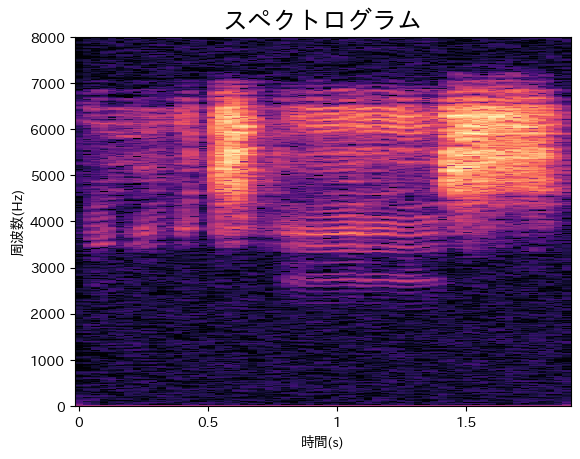

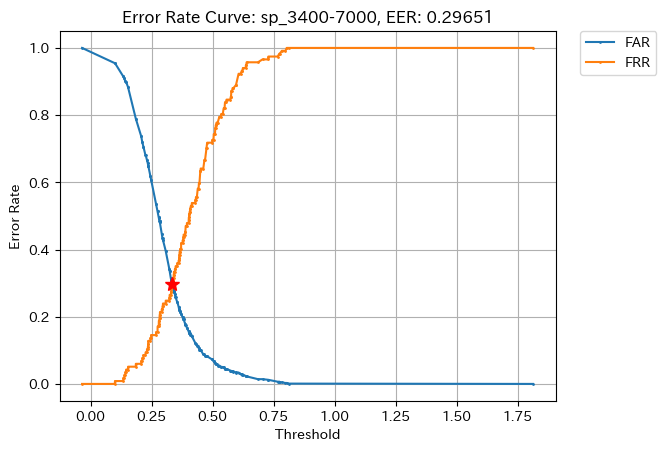

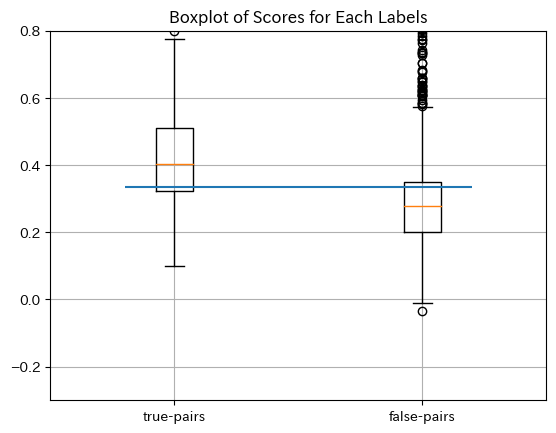

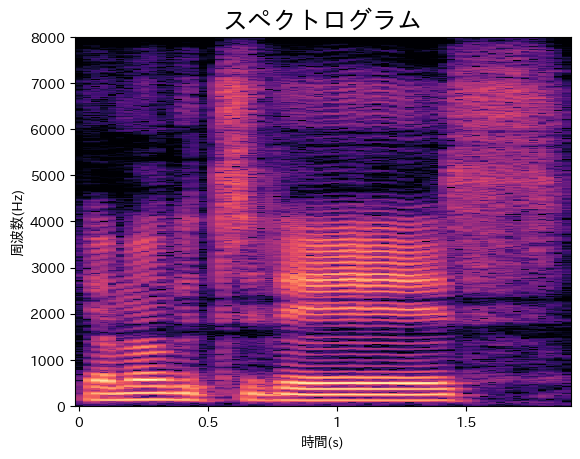

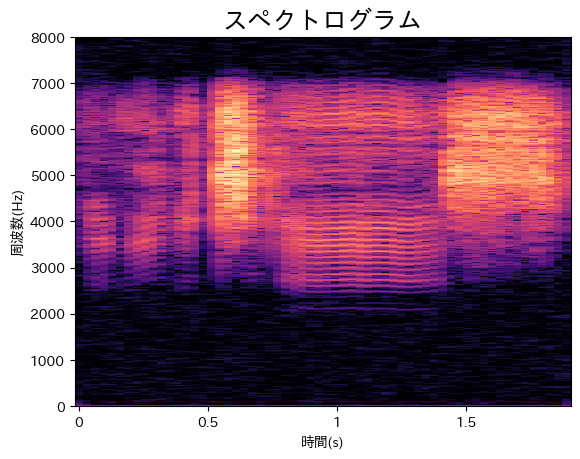

In [35]:
bpf_range = (3400, 7000)
run(bpf_range)